In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

model_id = "facebook/opt-125m"
model = AutoModelForCausalLM.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/251M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/251M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

AttributeError: 'OPTDecoder' object has no attribute 'layer'

In [ ]:
act_dict = {}

def get_activation_hook(name):
    def hook(model, input, output):
        act_dict[name] = input[0].detach().cpu()
    return hook

layer_name = 'decoder.layers.0.self_attn.q_proj2'
target_layer = model.model.decoder.layers[0].self_attn.q_proj
handle = target_layer.register_forward_hook(get_activation_hook(layer_name))

input_text = "SmoothQuant is a training-free, accuracy-preserving solution."
inputs = tokenizer(input_text, return_tensors="pt")

model(**inputs)

handle.remove()


activation = act_dict[layer_name] # Shape: [Batch, Seq_Len, Hidden_Dim]

weight = target_layer.weight.detach().cpu() # Shape: [Out_Dim, In_Dim]

print(f"Activation Shape: {activation.shape}")
print(f"Weight Shape: {weight.shape}")

# Q. 정말 Outlier가 있는지 확인해볼까요?
# Activation의 전체 값 중 최댓값
print(f"Activation Max Abs: {activation.abs().max().item()}")

# Weight의 전체 값 중 최댓값
print(f"Weight Max Abs: {weight.abs().max().item()}")

Activation Shape: torch.Size([1, 16, 768])
Weight Shape: torch.Size([768, 768])
Activation Max Abs: 3.1717495918273926
Weight Max Abs: 0.79931640625


In [ ]:
def calculate_smoothing_factor(activation, weight, alpha=0.5):
    # 1. Activation의 채널별 절댓값 최댓값 구하기 (Shape: [Hidden_Dim])
    # 힌트: activation을 2차원(-1, hidden_dim)으로 펴고, dim=0에 대해 max를 구하세요.
    act_abs = activation.abs()
    act_scales = act_abs.view(-1, activation.shape[-1]).max(dim=0)[0]

    # 2. Weight의 채널별 절댓값 최댓값 구하기 (Shape: [In_Dim])
    # 힌트: dim=0에 대해 max를 구하세요. (Linear Weight는 [Out, In] 이므로)
    weight_abs = weight.abs()
    weight_scales = weight_abs.max(dim=0)[0]

    # 0으로 나누는 것을 방지하기 위해 아주 작은 값을 더해줍니다 (선택 사항이지만 추천)
    weight_scales = torch.maximum(weight_scales, torch.tensor(1e-5))

    # 3. 공식 적용하여 scales 구하기
    # s = (act_scales ^ alpha) / (weight_scales ^ (1 - alpha))
    scales = torch.pow(act_scales, alpha) / torch.pow(weight_scales, (1 - alpha))

    return scales

# 실행 및 확인
scales = calculate_smoothing_factor(activation, weight)

print(f"Scales Shape: {scales.shape}") # 예상: [768] (OPT-125m의 Hidden size)
print(f"Calculated Scales (First 5): {scales[:5]}")

Scales Shape: torch.Size([768])
Calculated Scales (First 5): tensor([0.8951, 2.1828, 0.9946, 1.2399, 1.1639])


In [ ]:
# 1. Activation Smoothing (나누기)
# X_hat = X / s
act_s = scales.view(1,1,-1)
smoothed_act = activation / act_s

# 2. Weight Smoothing (곱하기)
# W_hat = W * s
w_s = scales.view(1, -1)
smoothed_weight = weight * w_s

# --- 검증 ---
print(f"Original Activation Max: {activation.abs().max().item():.2f}")
print(f"Smoothed Activation Max: {smoothed_act.abs().max().item():.2f}")

print("-" * 30)

print(f"Original Weight Max: {weight.abs().max().item():.4f}")
print(f"Smoothed Weight Max: {smoothed_weight.abs().max().item():.4f}")

Original Activation Max: 3.17
Smoothed Activation Max: 1.21
------------------------------
Original Weight Max: 0.7993
Smoothed Weight Max: 1.2111


In [ ]:
def fake_quantize(tensor):
    # 1. 스케일 계산 (Per-tensor static quantization 가정)
    scale = tensor.abs().max() / 127.0

    # 2. 양자화 (Round & Clamp)
    # tensor를 scale로 나누고 round() 한 뒤, -128 ~ 127 사이로 clamp 하세요.
    quant_int8 = torch.clamp(torch.round(tensor / scale) , -128, 127)

    # 3. 역양자화 (Dequantize)
    # 다시 scale을 곱해서 float으로 복구합니다.
    recon_tensor = scale * quant_int8

    return recon_tensor

# --- 검증 시작 ---

# 1. 정답 (FP16/FP32 Ground Truth)
# Linear Layer 계산: X @ W.T
output_gt = torch.matmul(activation, weight.t())

# 2. Naive W8A8 (그냥 원래 값 양자화)
act_naive_q = fake_quantize(activation)
w_naive_q = fake_quantize(weight)
output_naive = torch.matmul(act_naive_q, w_naive_q.t())

# 3. SmoothQuant (스무딩된 값 양자화)
# 위에서 만든 smoothed_act, smoothed_weight를 사용하세요.
act_smooth_q = fake_quantize(smoothed_act)
w_smooth_q = fake_quantize(smoothed_weight)
output_smooth = torch.matmul(act_smooth_q, w_smooth_q.t())

# 4. 오차 비교 (평균 절대 오차, Mean Absolute Error)
loss_naive = (output_gt - output_naive).abs().mean().item()
loss_smooth = (output_gt - output_smooth).abs().mean().item()

print(f"Naive Quant Error:   {loss_naive:.6f}")
print(f"SmoothQuant Error:   {loss_smooth:.6f}")

if loss_smooth < loss_naive:
    print("\n🎉 성공! SmoothQuant가 오차를 줄였습니다!")
else:
    print("\n🤔 흠, 뭔가 조정이 필요하네요.")

Naive Quant Error:   0.016647
SmoothQuant Error:   0.013843

🎉 성공! SmoothQuant가 오차를 줄였습니다!


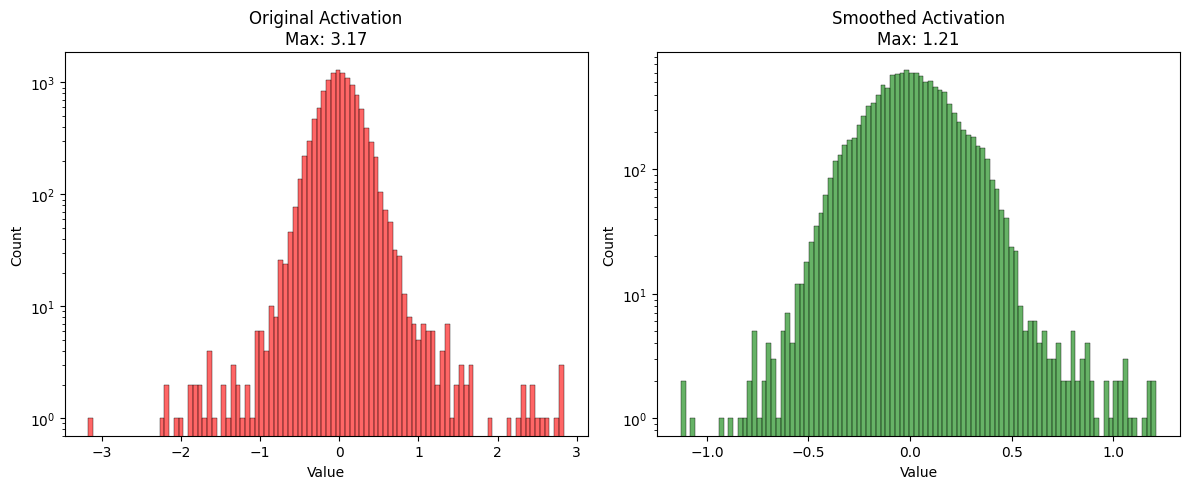

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distribution(original, smoothed):
    plt.figure(figsize=(12, 5))

    # 1. 원본 Activation 분포
    plt.subplot(1, 2, 1)
    sns.histplot(original.view(-1).numpy(), bins=100, color='red', alpha=0.6)
    plt.title(f"Original Activation\nMax: {original.abs().max():.2f}")
    plt.xlabel("Value")
    plt.yscale('log') # 로그 스케일로 봐야 Outlier가 잘 보입니다

    # 2. SmoothQuant 적용 후 분포
    plt.subplot(1, 2, 2)
    sns.histplot(smoothed.view(-1).numpy(), bins=100, color='green', alpha=0.6)
    plt.title(f"Smoothed Activation\nMax: {smoothed.abs().max():.2f}")
    plt.xlabel("Value")
    plt.yscale('log')

    plt.tight_layout()
    plt.show()

# 시각화 실행
# (데이터가 너무 많으면 느릴 수 있으니 일부만 샘플링해서 그립니다)
plot_distribution(activation[0], smoothed_act[0])